In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score


# this extension properly formats a cell after it is run
# !{sys.executable} -m pip install nb_black # UNCOMMENT TO INSTALL
%load_ext nb_black
%matplotlib inline

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)

# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [56]:
# The csv files were renamed in the last push from stat_train_set to train_set

train_set = pd.read_csv("../data/train_set.csv")
test_set = pd.read_csv("../data/test_set.csv")

<IPython.core.display.Javascript object>

In [57]:
# creating a function to create groups based on mean sale price of streets in each
# neighborhood of the training df and adds a new column with the groups created
# It then uses the groups created using the training dataframe and creates a new column
# in the testing dataframe by mapping these groups.  This will result in missing values
# If there is a street neighborhood combination that was in the training dataset but
# not the testing dataset


def group_neighbor_streets_by_saleprice(
    traindf=train_set,
    testdf=test_set,
    num_quantiles=10,  # notice the difference in this line!!
):
    # Calculate the mean sale price for each street in the training df
    street_prices = traindf.groupby("Neighborhood_st")["SalePrice"].mean()
    # Group the streets into the specified number of quantiles based on sale price
    labels = [f"group_{i+1}" for i in range(num_quantiles)]
    groups = pd.qcut(street_prices, q=num_quantiles, labels=range(1, num_quantiles + 1))
    # Create a dictionary that maps each street name to its corresponding sale price group label
    street_group_dict = dict(zip(street_prices.index, groups))
    # Add a new column to the training dataframe with the street price groups
    traindf["StreetPriceGroup"] = traindf["Neighborhood_st"].map(street_group_dict)
    # Add a new column to the testing dataframe with the street price groups
    testdf["StreetPriceGroup"] = testdf["Neighborhood_st"].map(street_group_dict)
    return street_group_dict


# this will use the dictionary created to fill in the missing values in the test df with
# another group in the same neighborhood


def fill_na(testdf=test_set, d={}):
    # Extract the first part of the string in the "Neighborhood_st" column
    testdf["Neighborhood_prefix"] = testdf["Neighborhood_st"].map(
        lambda x: x.split("_")[0]
    )
    # Create a new dict that only contains the neighborhood
    new_dict = {k.split("_")[0]: v for k, v in d.items()}
    # Create a list of PIDs with missing StreetPriceGroup values
    na_pid_list = testdf[testdf["StreetPriceGroup"].isna()]["PID"].tolist()
    # Create a Boolean mask to filter the DataFrame
    mask = testdf["PID"].isin(na_pid_list)
    # Apply the dictionary mapping only to the filtered rows
    testdf.loc[mask, "StreetPriceGroup"] = testdf[mask]["Neighborhood_prefix"].map(
        new_dict
    )
    # Drop the column since there is no more use for it
    testdf.drop("Neighborhood_prefix", axis=1, inplace=True)


# the num of quantiles can be changed and it is assigned to d which is the dictionary that
# will be used to fill in the missing values

d = group_neighbor_streets_by_saleprice(
    traindf=train_set, testdf=test_set, num_quantiles=10,
)

fill_na(test_set, d)


# Remove the column that was used to create groupings
# train_set.drop("Neighborhood_st", axis=1, inplace=True)
# test_set.drop("Neighborhood_st", axis=1, inplace=True)


# overly complicated code to remove PID and move SalePrice to first column
# I need to do this in the future and save the csv's after so we dont have to do this each time
train_set = train_set.iloc[
    :,
    train_set.columns.tolist().index("SalePrice") : (
        train_set.columns.tolist().index("SalePrice") + 1
    ),
].join(train_set.drop(columns=["SalePrice", "PID"]))
# same with test set
test_set = test_set.iloc[
    :,
    test_set.columns.tolist().index("SalePrice") : (
        test_set.columns.tolist().index("SalePrice") + 1
    ),
].join(test_set.drop(columns=["SalePrice", "PID"]))

<IPython.core.display.Javascript object>

In [15]:
# The below is an optional step for models that perform better with dummified data
# to be used dummify categorical columns after the functions above are
# used to add the Neighborhood_st groupings



# Creating a list of categorical columns to be dummified
cat_cols = train_set.select_dtypes(include=['object']).columns.tolist()

# Dummify the categorical columns in the train set
train_dummies = pd.get_dummies(train_set, columns=cat_cols)

# Dummify the categorical columns in the test set
test_dummies = pd.get_dummies(test_set, columns=cat_cols)

# Ensure the same dummy columns are present in both train and test sets
train_dummies, test_dummies = train_dummies.align(test_dummies, join='left', axis=1)

# Fill any missing columns in the test set with zeros
test_dummies.fillna(0, inplace=True)


<IPython.core.display.Javascript object>

In [54]:
test_set.isna().sum()

SalePrice            0
GrLivArea            0
MSSubClass           0
MSZoning             0
LotFrontage          0
LotArea              0
Street               0
Alley                0
LotShape             0
LandContour          0
Utilities            0
LotConfig            0
LandSlope            0
Neighborhood         0
Condition1           0
Condition2           0
BldgType             0
HouseStyle           0
OverallQual          0
OverallCond          0
YearBuilt            0
YearRemodAdd         0
RoofStyle            0
RoofMatl             0
Exterior1st          0
Exterior2nd          0
MasVnrType           0
MasVnrArea           0
ExterQual            0
ExterCond            0
Foundation           0
BsmtQual             0
BsmtCond             0
BsmtExposure         0
BsmtFinType1         0
BsmtFinSF1           0
BsmtFinType2         0
BsmtFinSF2           0
BsmtUnfSF            0
TotalBsmtSF          0
Heating              0
HeatingQC            0
CentralAir           0
Electrical 

<IPython.core.display.Javascript object>

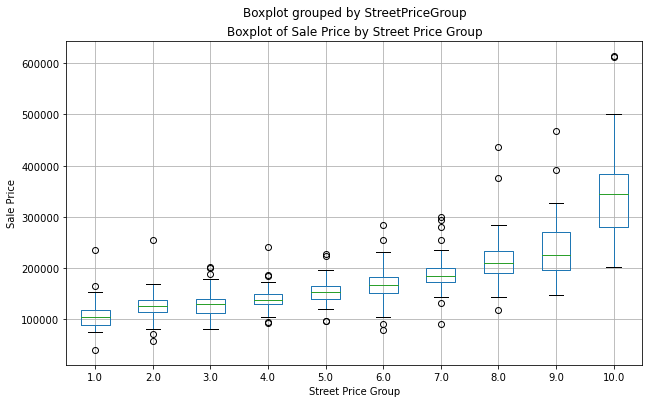

<IPython.core.display.Javascript object>

In [55]:
import matplotlib.pyplot as plt

# assuming your test_set dataframe has columns 'SalePrice' and 'StreetPriceGroup'
test_set.boxplot(column='SalePrice', by='StreetPriceGroup', figsize=(10,6))
plt.xlabel('Street Price Group')
plt.ylabel('Sale Price')
plt.title('Boxplot of Sale Price by Street Price Group')
plt.show()


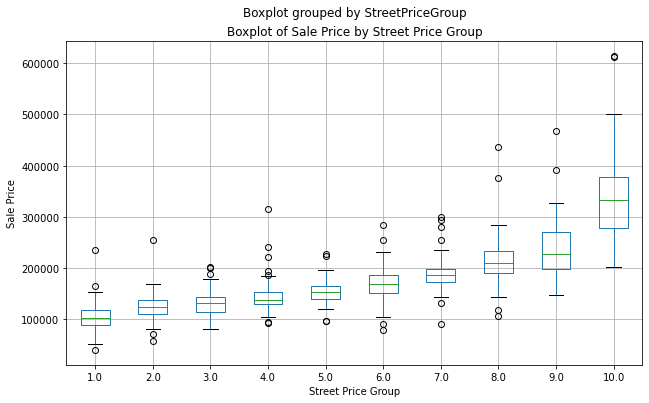

<IPython.core.display.Javascript object>

In [58]:
import matplotlib.pyplot as plt

# assuming your test_set dataframe has columns 'SalePrice' and 'StreetPriceGroup'
test_set.boxplot(column='SalePrice', by='StreetPriceGroup', figsize=(10,6))
plt.xlabel('Street Price Group')
plt.ylabel('Sale Price')
plt.title('Boxplot of Sale Price by Street Price Group')
plt.show()


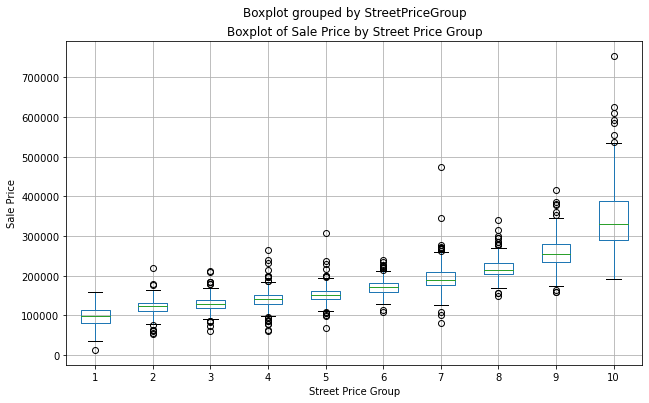

<IPython.core.display.Javascript object>

In [59]:
import matplotlib.pyplot as plt

# assuming your test_set dataframe has columns 'SalePrice' and 'StreetPriceGroup'
train_set.boxplot(column="SalePrice", by="StreetPriceGroup", figsize=(10, 6))
plt.xlabel("Street Price Group")
plt.ylabel("Sale Price")
plt.title("Boxplot of Sale Price by Street Price Group")
plt.show()

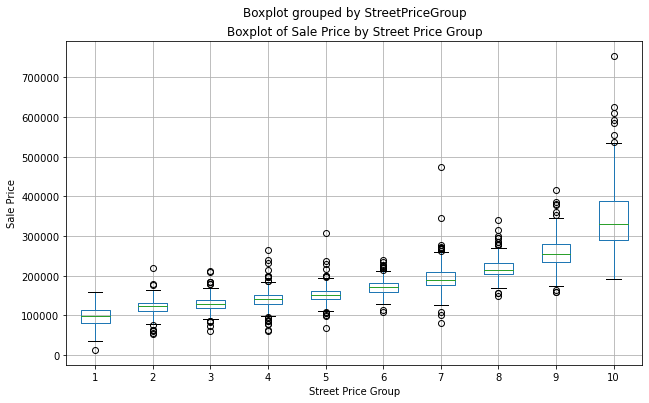

<IPython.core.display.Javascript object>

In [62]:
import matplotlib.pyplot as plt

# assuming your test_set dataframe has columns 'SalePrice' and 'StreetPriceGroup'
box_plot = train_set.boxplot(column='SalePrice', by='StreetPriceGroup', figsize=(10,6))
plt.xlabel('Street Price Group')
plt.ylabel('Sale Price')
plt.title('Boxplot of Sale Price by Street Price Group')
plt.show()

# get the outliers for each group
outliers = [flier.get_ydata() for flier in box_plot.get_children() if flier.get_label() == 'fliers']

# print the values of the outliers
for i, outlier_group in enumerate(outliers):
    print(f'Outliers for Group {i+1}: {outlier_group}')


In [66]:
grouped = train_set.groupby('StreetPriceGroup')

for name, group in grouped:
    print(f"StreetPriceGroup: {name}")
    print(f"Min YearBuilt: {group['YearBuilt'].min()}")
    print(f"Max YearBuilt: {group['YearBuilt'].max()}")
    print(f"Std YearBuilt: {group['YearBuilt'].std()}")
    print(f"Count: {group.shape[0]}")
    print('\n')


StreetPriceGroup: 1
Min YearBuilt: 1895
Max YearBuilt: 1977
Std YearBuilt: 22.12586719531163
Count: 168


StreetPriceGroup: 2
Min YearBuilt: 1885
Max YearBuilt: 2004
Std YearBuilt: 24.103175131116682
Count: 219


StreetPriceGroup: 3
Min YearBuilt: 1872
Max YearBuilt: 1993
Std YearBuilt: 23.382475749296265
Count: 205


StreetPriceGroup: 4
Min YearBuilt: 1875
Max YearBuilt: 2004
Std YearBuilt: 23.214531252675986
Count: 290


StreetPriceGroup: 5
Min YearBuilt: 1910
Max YearBuilt: 2009
Std YearBuilt: 25.457428111645406
Count: 190


StreetPriceGroup: 6
Min YearBuilt: 1921
Max YearBuilt: 2008
Std YearBuilt: 21.058697516447918
Count: 168


StreetPriceGroup: 7
Min YearBuilt: 1882
Max YearBuilt: 2010
Std YearBuilt: 25.251695260245256
Count: 293


StreetPriceGroup: 8
Min YearBuilt: 1880
Max YearBuilt: 2009
Std YearBuilt: 20.388579357114367
Count: 181


StreetPriceGroup: 9
Min YearBuilt: 1928
Max YearBuilt: 2008
Std YearBuilt: 21.266722913031494
Count: 178


StreetPriceGroup: 10
Min YearBuilt: 19

<IPython.core.display.Javascript object>

In [ ]:
grouped = train_set.groupby('StreetPriceGroup')

for name, group in grouped:
    print(f"StreetPriceGroup: {name}")
    print(f"Min YearBuilt: {group['YearBuilt'].min()}")
    print(f"Max YearBuilt: {group['YearBuilt'].max()}")
    print(f"Std YearBuilt: {group['YearBuilt'].std()}")
    print(f"Count: {group.shape[0]}")
    print('\n')


In [68]:

grouped = train_set.groupby('Neighborhood_st')

for name, group in grouped:
    print(f"StreetPriceGroup: {name}")
    print(f"Min YearBuilt: {group['YearBuilt'].min()}")
    print(f"Max YearBuilt: {group['YearBuilt'].max()}")
    print(f"Std YearBuilt: {group['YearBuilt'].std()}")
    print(f"Count: {group.shape[0]}")
    print('\n')


StreetPriceGroup: Blmngtn_BRICKMAN_AVE
Min YearBuilt: 2005
Max YearBuilt: 2007
Std YearBuilt: 1.4142135623730951
Count: 2


StreetPriceGroup: Blmngtn_LAKESIDE_DR
Min YearBuilt: 2003
Max YearBuilt: 2007
Std YearBuilt: 1.6733200530681511
Count: 5


StreetPriceGroup: Blmngtn_WESTWIND_DR
Min YearBuilt: 2002
Max YearBuilt: 2007
Std YearBuilt: 1.6787441193290353
Count: 12


StreetPriceGroup: Blueste_LITTLE_BLUESTEM_CT
Min YearBuilt: 1980
Max YearBuilt: 1989
Std YearBuilt: 4.166190448976482
Count: 8


StreetPriceGroup: BrDale_BARKLEY_CT
Min YearBuilt: 1971
Max YearBuilt: 1972
Std YearBuilt: 0.3779644730092272
Count: 7


StreetPriceGroup: BrDale_BRECKINRIDGE_CT
Min YearBuilt: 1972
Max YearBuilt: 1972
Std YearBuilt: 0.0
Count: 3


StreetPriceGroup: BrDale_TRUMAN_PL
Min YearBuilt: 1970
Max YearBuilt: 1973
Std YearBuilt: 1.12089707663561
Count: 13


StreetPriceGroup: BrkSide_10TH_ST
Min YearBuilt: 1921
Max YearBuilt: 1948
Std YearBuilt: 12.192894105447921
Count: 4


StreetPriceGroup: BrkSide_12TH

Std YearBuilt: 1.0
Count: 9


StreetPriceGroup: NridgHt_BRIDGEPORT_DR
Min YearBuilt: 2001
Max YearBuilt: 2002
Std YearBuilt: 0.7071067811865476
Count: 2


StreetPriceGroup: NridgHt_BURNHAM_DR
Min YearBuilt: 2002
Max YearBuilt: 2008
Std YearBuilt: 1.873795909674026
Count: 10


StreetPriceGroup: NridgHt_CHILTON_AVE
Min YearBuilt: 2003
Max YearBuilt: 2006
Std YearBuilt: 1.7320508075688772
Count: 4


StreetPriceGroup: NridgHt_FARNHAM_DR
Min YearBuilt: 2003
Max YearBuilt: 2004
Std YearBuilt: 0.7071067811865476
Count: 2


StreetPriceGroup: NridgHt_FOXLEY_DR
Min YearBuilt: 2003
Max YearBuilt: 2003
Std YearBuilt: 0.0
Count: 4


StreetPriceGroup: NridgHt_HARRISON_RD
Min YearBuilt: 2003
Max YearBuilt: 2006
Std YearBuilt: 0.9102589898327995
Count: 15


StreetPriceGroup: NridgHt_HASTINGS_AVE
Min YearBuilt: 2004
Max YearBuilt: 2005
Std YearBuilt: 0.7071067811865476
Count: 2


StreetPriceGroup: NridgHt_PRESTON_CIR
Min YearBuilt: 2004
Max YearBuilt: 2007
Std YearBuilt: 1.0327955589886446
Count: 6


S

<IPython.core.display.Javascript object>

In [72]:
housing = pd.read_csv("../data/housing_cleaned.csv")
locations = pd.read_csv("../data/locations.csv")

<IPython.core.display.Javascript object>

In [73]:
# merging Neigborhood_st column
housing = housing.merge(locations[["PID", "Neighborhood_st"]], on="PID", how="left")

<IPython.core.display.Javascript object>

In [75]:
housing.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive',

<IPython.core.display.Javascript object>

In [ ]:
# Random Forest Model

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the features and target variables
X_train = train_dummies.iloc[:, 1:]
y_train = train_dummies.iloc[:, 0]
X_test = test_dummies.iloc[:, 1:]
y_test = test_dummies.iloc[:, 0]

# Create the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Train the model using the training data
rf_model.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R-squared:", r2)


MSE: 938915437.8668282
R-squared: 0.8310523393667286


<IPython.core.display.Javascript object>

In [ ]:
# Bagging with Random forest regressor

In [6]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Create a bagging regressor that uses the random forest regressor as its base estimator
bagged_rf = BaggingRegressor(base_estimator=rf, n_estimators=10, random_state=42)

# Train the bagged random forest model
bagged_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = bagged_rf.predict(X_test)

# Calculate and print the mean squared error and R-squared score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R-squared:", r2)

# Evaluate the performance using cross-validation
scores = cross_val_score(bagged_rf, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


MSE: 699842332.1764544
R-squared: 0.8740709545665016
Cross-validation scores: [0.90968627 0.86639383 0.91057159 0.91607776 0.9055749 ]
Mean cross-validation score: 0.9016608704524254


<IPython.core.display.Javascript object>

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Fit the random forest regressor on the training data
rf.fit(X_train, y_train)

# Calculate feature importance scores
importances = rf.feature_importances_

# Sort feature importance scores in descending order
sorted_idx = importances.argsort()[::-1]

# Print feature importance scores in descending order
for idx in sorted_idx:
    print(f"{X_train.columns[idx]}: {importances[idx]}")


StreetPriceGroup: 0.686474111033417
TotalSF: 0.14965716810843663
OverallQual: 0.0368494134633035
GrLivArea: 0.01683656123005996
LotArea: 0.006400351489854686
GarageArea: 0.006237865493537361
BsmtQual: 0.005849786248989694
TotalBath: 0.005470208139632794
MasVnrArea: 0.005429907162790061
RemodAge: 0.004389311013668147
BsmtFinSF1: 0.004131713258686749
BsmtUnfSF: 0.003975664251476593
TotalBsmtSF: 0.0038971936475027695
YearRemodAdd: 0.003392725930613729
OverallCond: 0.003300786905738421
KitchenQual: 0.003258295536595878
2ndFlrSF: 0.0029999429928729434
1stFlrSF: 0.002984671418701909
WoodDeckSF: 0.0026828477240081997
GarageYrBlt: 0.0025966129036616593
TotalPorchSF: 0.0024622842334844275
Age: 0.002200457451226555
LotFrontage: 0.0021576367911582536
YearBuilt: 0.0018376136954996822
GarageCars: 0.0016462218219815785
BsmtFinType1: 0.0015308907686646435
MoSold: 0.0014983109823526373
OpenPorchSF: 0.0014273432848999983
ExterQual: 0.0011771929000584554
Fireplaces: 0.0011103152603265287
MSZoning_RL: 0.

<IPython.core.display.Javascript object>

## Looping through quantiles and plotting R squared ##

In [83]:
def preprocess_data(train_set, test_set, num_quantiles):
    # Keep the 'PID' column before dummification
    test_pids = test_set['PID']

    # Group the streets and fill any missing values in the test set
    d = group_neighbor_streets_by_saleprice(train_set, test_set, num_quantiles)
    fill_na(test_set, d, test_pids)

    # Drop the 'Neighborhood_st' column
    train_set = train_set.drop(columns=["Neighborhood_st"])
    test_set = test_set.drop(columns=["Neighborhood_st"])

    # Create a list of categorical columns to be dummified
    cat_cols = train_set.select_dtypes(include=['object']).columns.tolist()

    # Dummify the categorical columns in the train set
    train_dummies = pd.get_dummies(train_set, columns=cat_cols)

    # Dummify the categorical columns in the test set
    test_dummies = pd.get_dummies(test_set, columns=cat_cols)

    # Ensure the same dummy columns are present in both train and test sets
    train_dummies, test_dummies = train_dummies.align(test_dummies, join='left', axis=1)

    # Fill any missing columns in the test set with zeros
    test_dummies.fillna(0, inplace=True)

    return train_dummies, test_dummies


<IPython.core.display.Javascript object>

In [84]:
def fill_na(testdf, d, test_pids):
    new_dict = {k.split("_")[0]: v for k, v in d.items()}
    # Create a list of PIDs with missing StreetPriceGroup values
    na_pid_list = testdf[testdf["StreetPriceGroup"].isna()]["PID"].tolist()
    # Create a Boolean mask to filter the DataFrame
    mask = testdf["PID"].isin(na_pid_list)
    # Fill the missing StreetPriceGroup values
    testdf.loc[mask, ] = testdf.loc[mask, "Neighborhood_st"].map(new_dict)
    # Drop the 'PID' column and add it back
    testdf.drop(columns=['PID'], inplace=True)
    testdf['PID'] = test_pids


<IPython.core.display.Javascript object>

In [87]:
def fill_na(testdf, d, test_pids):
    new_dict = {k.split("_")[0]: v for k, v in d.items()}
    # Create a list of PIDs with missing StreetPriceGroup values
    na_pid_list = testdf[testdf["StreetPriceGroup"].isna()]["PID"].tolist()
    # Create a Boolean mask to filter the DataFrame
    mask = testdf["PID"].isin(na_pid_list)
    # Fill the missing StreetPriceGroup values
    testdf.loc[mask, "StreetPriceGroup"] = testdf.loc[mask, "Neighborhood_st"].map(new_dict)
    # Drop the 'PID' column and reset the index
    testdf.drop(columns=['PID'], inplace=True)
    testdf.reset_index(drop=True, inplace=True)
    # Add the 'PID' column back
    testdf['PID'] = test_pids
    return testdf


<IPython.core.display.Javascript object>

In [88]:
def evaluate_quantile_grouping(train_data, test_data, target_col='SalePrice'):
    X_train = train_data.drop(columns=[target_col])
    y_train = train_data[target_col]
    X_test = test_data.drop(columns=[target_col])
    y_test = test_data[target_col]

    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2


<IPython.core.display.Javascript object>

In [93]:
r2_values = []

for num_quantiles in range(3, 60):
    # Load the data for each iteration
    train_set = pd.read_csv("../data/train_set.csv")
    test_set = pd.read_csv("../data/test_set.csv")

    # Preprocess the data
    train_copy, test_copy = preprocess_data(train_set.copy(), test_set.copy(), num_quantiles)

    # Evaluate the model and append the R-squared value
    r2 = evaluate_quantile_grouping(train_copy, test_copy)
    r2_values.append(r2)


<IPython.core.display.Javascript object>

In [90]:
r2_values

[0.8950550393031182,
 0.8802949312914684,
 0.834547319391115,
 0.7996503446289759,
 0.8051025872918858,
 0.8139288405252605,
 0.8026866149927379,
 0.7972575539384241,
 0.8078035979507707,
 0.8049516692489149,
 0.8087156052996158,
 0.7927100028447076,
 0.7968965956576439,
 0.783471926338398,
 0.7923978082615744,
 0.7956037987122053,
 0.7889877314147311,
 0.7889381521422958,
 0.7867911295782163,
 0.7895733817034732,
 0.788034126695904,
 0.7894062858722879,
 0.7864110454731758,
 0.7903678958492377,
 0.7863843823491553,
 0.7886580065997488,
 0.7940740435986642,
 0.7815227994882498,
 0.7780166735261037,
 0.7826714831705012,
 0.7864081825734468,
 0.7840722939158192,
 0.7856467213510814,
 0.7832668386822367,
 0.7891485777384502,
 0.7838929087170661,
 0.7830748594597394,
 0.7792970088248803,
 0.7809614003988358,
 0.7757303462858706,
 0.7791938405263005,
 0.7767565074984446,
 0.7786453644100275,
 0.7807141028788279,
 0.7770966957892516,
 0.7773412915709349,
 0.7810876172719161,
 0.7801640800782

<IPython.core.display.Javascript object>

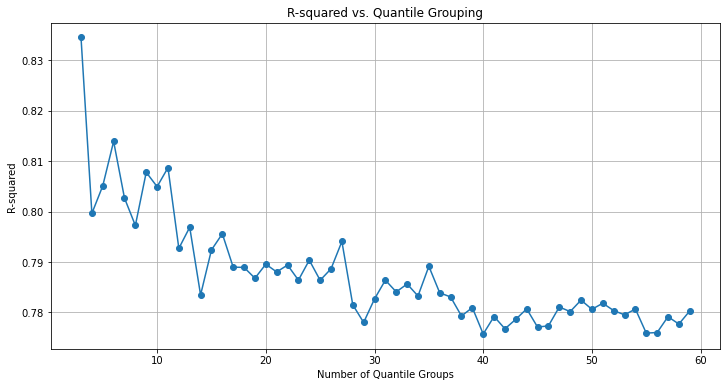

<IPython.core.display.Javascript object>

In [94]:
plt.figure(figsize=(12, 6))
plt.plot(range(3, 60), r2_values, marker='o')
plt.xlabel('Number of Quantile Groups')
plt.ylabel('R-squared')
plt.title('R-squared vs. Quantile Grouping')
plt.grid(True)
plt.show()


## R Squared in Linear Model with different groupings ##

In [44]:
## Linear Model ##

<IPython.core.display.Javascript object>

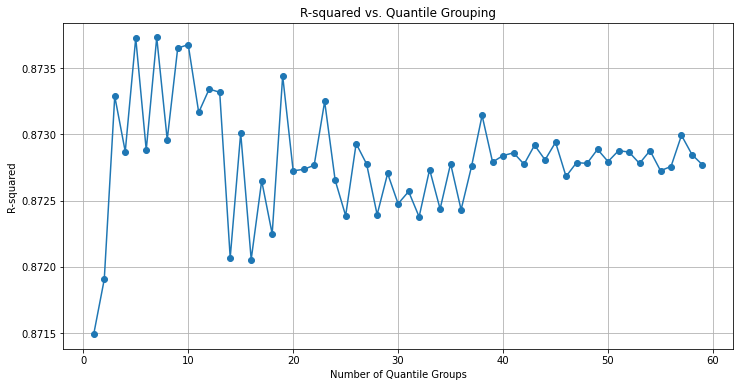

<IPython.core.display.Javascript object>

In [42]:
from sklearn.linear_model import LinearRegression

def evaluate_quantile_grouping(train_data, test_data, target_col='SalePrice'):
    X_train = train_data.drop(columns=[target_col])
    y_train = train_data[target_col]
    X_test = test_data.drop(columns=[target_col])
    y_test = test_data[target_col]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

r2_values = []

for num_quantiles in range(1, 60):
    # Load the data for each iteration
    train_set = pd.read_csv("../data/train_set.csv")
    test_set = pd.read_csv("../data/test_set.csv")

    # Preprocess the data
    train_copy, test_copy = preprocess_data(train_set.copy(), test_set.copy(), num_quantiles)

    # Evaluate the model and append the R-squared value
    r2 = evaluate_quantile_grouping(train_copy, test_copy)
    r2_values.append(r2)

plt.figure(figsize=(12, 6))
plt.plot(range(1, 60), r2_values, marker='o')
plt.xlabel('Number of Quantile Groups')
plt.ylabel('R-squared')
plt.title('R-squared vs. Quantile Grouping')
plt.grid(True)
plt.show()
